# Analysis of tutoring center sign-in data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
import seaborn as sns
import os
import glob as glob
plt.rcParams['figure.figsize'] = (10.0, 8.0)

D:\Users\jconning\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#export_files = glob.iglob(r'C:\Users\Av\Dropbox\sign_in_exports\*.csv')
export_files = glob.iglob(r'D:\Users\jconning\Dropbox\sign_in_exports\*.csv')

#sort by most recently updated export
newest = max(export_files, key=os.path.getmtime)
df = pd.read_csv(newest)

update_date_unix = os.path.getmtime(newest)
update_date = datetime.fromtimestamp(update_date_unix)
print("Current file was updated on: " + str(update_date.strftime("%b %d %Y %H:%M:%S")))

Current file was updated on: Dec 19 2015 12:59:56


Let's now create a datetime index to get days of the week and other datetime functions below.

In [3]:
df['timestamp'] = pd.to_datetime(df.Date + ' ' + df.Time)
df = df.set_index(pd.DatetimeIndex(df.timestamp))

In [4]:
weekmask =['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

df['day'] = [weekmask[date.dayofweek] for date in df.index]
#makes weekdays into a category ordered by weekmask order
df['day']= df['day'].astype('category')
df['day']
df['day']=  df['day'].cat.reorder_categories(weekmask[0:7], ordered=True)

df['hour']= [date.hour for date in df.index]


#### The most popular days of the week:

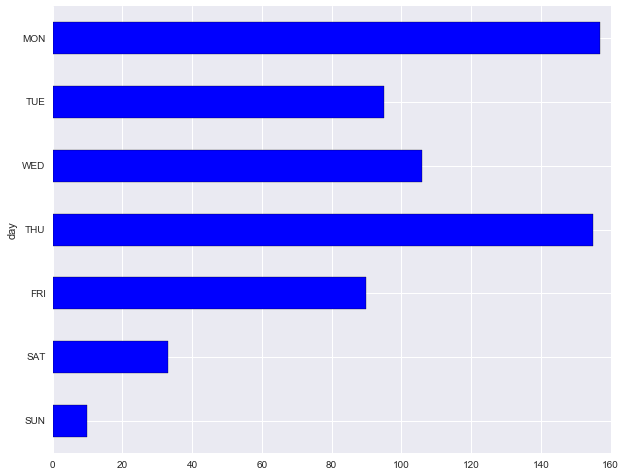

In [5]:
grouped = df.groupby('day').size().sort_index(ascending= False).plot(kind='barh')

Group by day and hour to count the number of visits in each day-hour cell.  Then reset_index to convert the (day,hour) multindex into a dataframe with columns for day, hour and visits.  After all that use a (groupby) pivot table to create the df_heatmap dataframe with hour rows and day columns. Exclude visits that might have been misclassified as having happened outside tutoring hours (8am-9pm).  Note: these get created when no hour was indicated on the sign-in.

In [6]:
dfu = pd.DataFrame(df.groupby([df.day,df.hour]).size())
dfu.reset_index(inplace=True) 
dfu.columns = ['hour','day', 'visits']

In [7]:
df_heatmap = dfu.pivot('day','hour','visits').fillna(0)
df_heatmap = df_heatmap.loc[8:21,]

A heatmap of the popular Weekdays/Hours to visit the tutoring center.

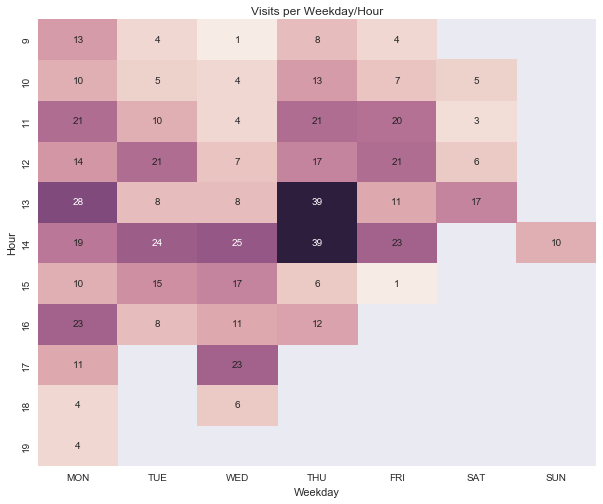

In [8]:
# Heatmap ignores values in mask. 
mask = ( df_heatmap ==0)
sns.heatmap(df_heatmap, annot=True, mask = mask,cbar=False)
plt.ylabel('Hour')
plt.xlabel('Weekday')
plt.title('Visits per Weekday/Hour')
plt.show()

# Summary statistics

Let's get a cumulative visits time-series

In [9]:
day_count = df.groupby('Date').size()
df_Day = pd.DataFrame({'Count': day_count})

Fill in the missing dates 

In [10]:
idx = pd.date_range(df_Day.index.min(), df_Day.index.max())
df_Day.index = pd.DatetimeIndex(df_Day.index)
df_day = df_Day.reindex(idx,fill_value=0)

## Visits by date

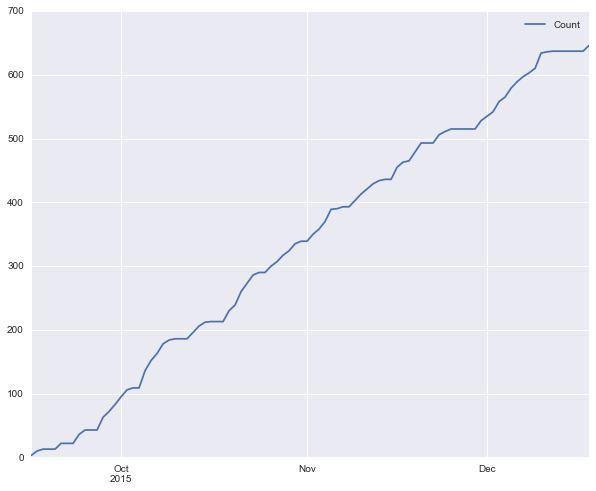

In [11]:
df_day.cumsum().plot()

## By course and instructor

In [12]:
byCourse = df.groupby(['Catalog Num'])
df_Course = byCourse.size().sort_values(ascending=False)
df_Course

Catalog Num
10000    162
30000    117
20000    101
22100     58
34000     46
30100     30
34500     27
20100     27
32100     26
35500     25
36500     10
21000      4
33000      4
26000      3
73200      1
39556      1
36600      1
30500      1
dtype: int64

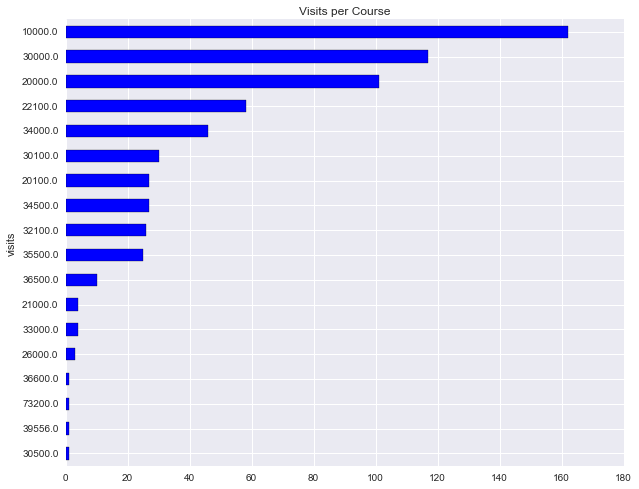

In [17]:
df_Course.sort_values().plot(kind='barh')
plt.ylabel("visits")
plt.title('Visits per Course')
plt.show()

In [14]:
byCourseProf = df.groupby(['Catalog Num','Instructor'])
df_CourseProf = byCourseProf.size().sort_values(ascending=False)
df_CourseProf

Catalog Num  Instructor  
10000        George          114
30000        Wright          110
20000        Basu             64
34000        Conning          46
22100        Nugent           35
10000        Filer            28
34500        Sevak            27
35500        George           25
30100        Silverstein      23
32100        Gharehogozli     23
20000        Deb              20
             Nugent           14
22100        Leboeuf          14
10000        Goodspeed        14
20100        Abreu            14
22100        Demir             9
36500        Ma                8
20100        Khajavi           8
30100        Agbeyegbe         7
10000        Chernick          6
30000        Nyman             5
20100        Agbeyegbe         5
21000        Osborne           4
33000        Gurevich          4
26000        Nyman             3
32100        Leboeuf           3
20000        Sevak             3
30000        Golbe             2
36500        Lu                2
39556        Chat

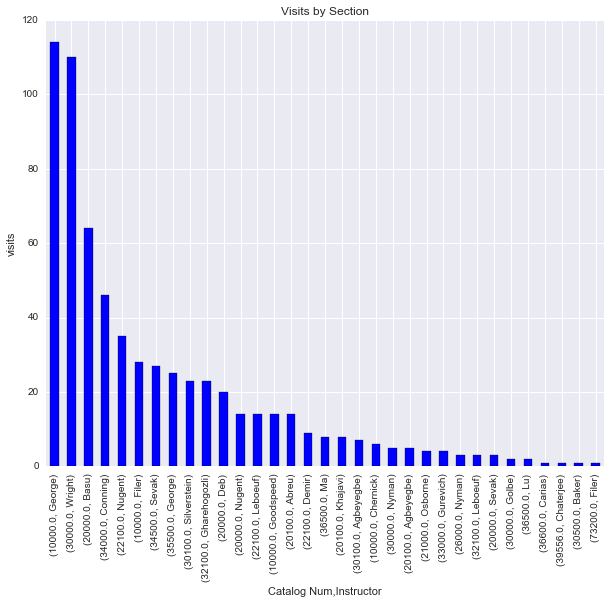

In [15]:
df_CourseProf.sort_values(ascending=False).plot(kind='bar')
plt.ylabel("visits")
plt.title('Visits by Section')
plt.ylabel("visits")
plt.show()

##  Some things we could do
   -  Number of unique visitors 
   -  Cumulative plot could disagregate by Purpose (drop-in, review)
   -  Agree on condensed summary report to send profs
       - 'this week'
       - 'semester to date'
   - more detailed report to profs
       - list of students
 